In [1]:
# Code outline:
# 1. Indoor system - data:
#   a. Read data and parameters
#   b. process data (measurements)
# 2. Outdoor system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light HOBO data
# 3. Offshore system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light IMS data
# 4. Calculate model results for:
#   a. Indoor system
#   b. Outdoor system
#   c. Offshore system
# 5. Calculate errors in the combined df
# df_combined structure:
#System, time, m_exp, m_mod, m_SRE,Nint_exp, Nint_mod, Nint_SRE Next_exp, Next_mod, Next_SRE
# 6... minimize errors?

In [2]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.0.1


In [3]:
# Functions for optimization (i.e producing random parametric combination)
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression

In [4]:
# 2. Outdoor system - data:
#   a. Read data and parameters

#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)
    
# Import outdoor data into df3
df3 = x2.parse('Outdoor')

# no need to read parameters now - may need later on if need to change parameters between systems 

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0


In [5]:
# parameters for minimum combined error:
miu = 0.04 #0.029
losses20 = 0.004
Nintmax = 4.25
Nintcrit = 3.5 #2.9
dNextoutdt = 0.008
Ks = 25.8
Vmax = 150 #93.7 - high vmax for ammonium
KI = 15.2
K0 = 2.4 #2.1
Ka = 0.12 #0.075
Smin = 0 #2.5 #5
Sopt = 28 #34
Smax = 45
Topt = 21.9
Tmax = 35.9
n = 5.1

In [6]:
# b. process data (outdoor measurements)
    # 1. Convert Time into hours
T = []
for i in df3['Sample'][:]:
    T1 = df3['Timeh'][df3['Sample'].values.tolist().index(i)]
    T2 = df3['Time'][df3['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
    
df3.loc[:,'T'] = T
    # 2. Make a temp df (df3_temp) by filtering the original df - remove irrelevant results (i.e not ulva, etc) 
df3f = df3[(df3.Stage == 'f')]
df3i = df3[(df3.Stage == 'i')]
# DWi = df3i.DW
# Ni = df3i.N
df3f = df3f.assign(DWi = df3i.DW.values)
df3f = df3f.assign(Ni = df3i.N.values)


df3Reduced = df3f[(df3f.Species == 'Ulva') & 
                  (df3f.Water == 'Seawater') & 
                  (df3f['Comment 2'] != 'Shaded') & 
                  (np.isnan(df3f.Ni) != True) & 
                  (np.isnan(df3f.mm) != True) &
                  (df3f['Sample'] >= 62) &
                  (df3f['Sample'] <= 522) &
                  (df3f.mm != 0) &
                  (df3f.Degredation != 'Yes')]
#'Shaded' was removed in order to avoid the need to add a shade function - this can be added later on 

df3Reduced#.head()

,Sample,Exp,Sleeve,Stage,Days,Timei,Timeh,Time,DW,mm,...,Species,Generation,Degredation,Age,Age 2,Comment,Comment 2,T,DWi,Ni
135,63.13,11,2,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.105270,7.368466,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.233347,2.942855
137,65.13,11,4,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.249991,8.333277,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.466693,3.080304
138,66.13,11,5,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.383512,9.223416,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.583367,2.672773
164,82.14,12,10,f,14.0,"2019,02,28,12,0","2019,02,28,12,0","2019,03,13,12,0",1.518620,10.124134,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,312,0.350020,3.492575
212,106.13,14,11,f,13.0,"2019,03,28,12,0","2019,03,28,12,0","2019,04,10,12,0",1.636927,10.912846,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,312,0.700040,3.649515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,516.14,50,1,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.034052,6.893683,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.789226
1038,517.14,50,2,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.060747,7.071649,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.789226
1039,518.14,50,3,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.235431,8.236204,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.789226
1041,520.14,50,5,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.230390,8.202602,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,2.070952


In [7]:
# c. Organize temperature and light HOBO data (interpolations functions will come later)
    # 1. Import HOBO excel
x3 = pd.ExcelFile('../data/HOBO.xlsx')
df3HOBO = x3.parse('Outdoor')

    # 2. light and temperature function - import data
import re

xHOBO = pd.ExcelFile('../data/HOBO.xlsx')
dfHOBO = xHOBO.parse('Outdoor',header=None)

dfHOBO

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total Air 2019 27.02.-2020 28.10.. Mikhmoret....,NaN,NaN,NaN,NaN,NaN,NaN,Total Water 2019 14.02.-2020 28.10.. Mikhmoret...,NaN,NaN,NaN,NaN,NaN
2,NaN,Date Time. GMT +0200,Temp. °C,Intensity. lux,NaN,NaN,NaN,#,Date Time,Temp. °C,Intensity. lux,Intensity [umol photons/m2/second],PAR
3,#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-02-27 15:46:45,17.07,2 317,NaN,NaN,NaN,1,2019-02-14 17:13:19,15.14,158,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1328,2020-10-28 07:24:24,26.55,1 228,NaN,NaN
59679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1329,2020-10-28 07:39:24,26.64,1 283,NaN,NaN
59680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1330,2020-10-28 07:54:24,26.81,1 557,NaN,NaN
59681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1331,2020-10-28 08:09:24,26.98,1 628,NaN,NaN


In [8]:
# 2. light data - fill up missing data and convert all data to float - save in Iwater

IHOBO = dfHOBO.iloc[4:59683:1][10]
Iwater = []
for i in IHOBO:
    if type(i) == int:
        i = str(i)
    Iwater.append(float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [9]:
# 2. Temperature data - fill up missing data and convert all data to float - save in Twater

THOBO = dfHOBO.iloc[4:59683:1][9]
Twater = []
for i in THOBO:
    if type(i) == int or float:
        i = str(i)
    Twater.append(float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [10]:
# 2. light and temperature data - save average hourly values in TV_average and IV_average

IV, IV_average, TV, TV_average = [],[],[],[]
for vali,valT in zip(Iwater,dfHOBO.iloc[3:59683:1][9]):
    IV.append(vali*0.019*0.43) # 0.019 - unit conversion, 0.43 - PAR
    TV.append(float(valT))
for i in range(1,len(IV),4):
    IV_average.append(np.mean(IV[i:i+4:1]))
    TV_average.append(np.mean(TV[i:i+4:1]))

In [11]:
# 4. Calculate model results for:

In [12]:
#   b. Outdoor system
    # I. Produce an array ("m/Nint_mod") of all model results for final m value (depends on m0, time, light, T and more) - done by runing the model in a loop
    
    
    # *requires model function with constant Next 
    #II. Add relevant columns from df3_temp and the model results to a new df_combined

In [13]:
df3Reduced

,Sample,Exp,Sleeve,Stage,Days,Timei,Timeh,Time,DW,mm,...,Species,Generation,Degredation,Age,Age 2,Comment,Comment 2,T,DWi,Ni
135,63.13,11,2,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.105270,7.368466,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.233347,2.942855
137,65.13,11,4,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.249991,8.333277,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.466693,3.080304
138,66.13,11,5,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.383512,9.223416,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.583367,2.672773
164,82.14,12,10,f,14.0,"2019,02,28,12,0","2019,02,28,12,0","2019,03,13,12,0",1.518620,10.124134,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,312,0.350020,3.492575
212,106.13,14,11,f,13.0,"2019,03,28,12,0","2019,03,28,12,0","2019,04,10,12,0",1.636927,10.912846,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,312,0.700040,3.649515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,516.14,50,1,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.034052,6.893683,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.789226
1038,517.14,50,2,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.060747,7.071649,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.789226
1039,518.14,50,3,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.235431,8.236204,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.789226
1041,520.14,50,5,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.230390,8.202602,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,2.070952


In [14]:
# optimized parameters: bounds

problem = {
    'num_vars': 6,
    'names': ['µmax','Nintcrit','KI','Ka','Topt','Tmax'],
    'bounds': [[0.025, 0.05],
               [0.7,3.2],
               [15, 150],
               [0.01,0.2],
               [15, 25],
               [31,37]]
}

print(problem)

{'num_vars': 6, 'names': ['µmax', 'Nintcrit', 'KI', 'Ka', 'Topt', 'Tmax'], 'bounds': [[0.025, 0.05], [0.7, 3.2], [15, 150], [0.01, 0.2], [15, 25], [31, 37]]}


In [15]:
# number of examined values per parameter - 10
param_values = saltelli.sample(problem, 50)
print(param_values.shape)

(700, 6)


In [16]:
VA = 64.3 / (0.261 * 3.14 * 0.5 * 1.2) # units: [g DW/ m^2] # d = 0.261m, h = 1.2m, A = h*d*pi*0.5
K0 = 0 # light is measured inside the water, so K0 is not relevant

# model simulations with different parameteric combinations


Y1 = np.zeros([param_values.shape[0]])
Y2 = np.zeros([param_values.shape[0]])

evaluate_model1 = []
evaluate_model2 = []

S = 39 # fix salinity function and S=40

r = 0

mSRE2, NintSRE2 = [], []
Samples = df3Reduced.Sample.values
Next_0 = 35


for p, X in enumerate(param_values):
    miu = X[0]
    Nintcrit = X[1]
    KI = X[2]
    Ka = X[3]
    Topt = X[4]
    Tmax = X[5]

    mmod_all,mSRE2Exp,Nintmod_all,NintSRE2Exp = [],[],[],[]
    mSRE2, NintSRE2 = [], []
    mmodAll, mSRE2All, NintmodAll, NintSRE2All = [],[],[],[]

    for i in Samples:
        df3Temp = df3Reduced[df3Reduced.Sample == i] 
        m_0 = df3Temp.DWi
        Nint_0 = df3Temp.Ni
        tf = df3Temp['T'].values
        t = np.arange(tf)
        T1 = '2019,02,14,17,0'
        T2 = df3Temp['Timei']
        T2 = T2.tolist()[0]
        t0 = Time_to_Hours(T1,T2)

        # light function
        IV_reduced = IV_average[t0:t0+t[-1]+1]

        fI0 = interpolate.interp1d(t, IV_reduced,kind = 'linear',bounds_error=False, fill_value="extrapolate")

        # T function
        TV_reduced = TV_average[t0:t0+t[-1]+1]
        fTemp0 = interpolate.interp1d(t, TV_reduced,kind = 'linear',bounds_error=False, fill_value="extrapolate")

        #print('\nSample: #' + str(math.floor(i)))

        mexp = df3Temp.DW
        mexp = mexp.tolist()[0]
        Nintexp = df3Temp.N
        Nintexp = Nintexp.tolist()[0]

        NEXT, NINT, M, TT = [],[],[],[]

        x0 = [Next_0,Nint_0,m_0]  
        #for hour in range(t):
        # setup initial conditions

        x = odeint(constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                                   Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

        NEXT.append(x[:,0])
        NINT.append(x[:,1])
        M.append(x[:,2])
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

        mmod = m_model[-1]
        mSRE2.append(((mexp-mmod)/mmod)**2)

        Nintmod = Nint_model[-1]
        NintSRE2.append(((Nintexp-Nintmod)/Nintmod)**2)

    cleanedNintSRE2 = [x for x in NintSRE2 if str(x) != 'nan']
    RMSREm2 = round((np.mean(mSRE2))**0.5,3)
    RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)

      
    evaluate_model1.append(RMSREm2)
    evaluate_model2.append(RMSRENint2)

    Y1[p] = round(evaluate_model1[-1],3)
    Y2[p] = round(evaluate_model2[-1],3)
    print(r)
    r = r+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
print(min(Y1))
print(np.mean(Y1))
print(np.std(Y1))
print(np.median(Y1))
print(max(Y1))

0.439
4.087828571428571
1.644488567231497
4.3385
7.45


In [18]:
Si1 = sobol.analyze(problem, Y1,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
µmax 0.152386 0.131841 0.114350 0.058662
Nintcrit -0.000023 0.000040 0.000000 0.000000
KI 0.454711 0.198035 0.398668 0.166860
Ka 0.321534 0.223007 0.306526 0.153325
Topt -0.014750 0.043294 0.013442 0.006424
Tmax 0.198935 0.148916 0.219694 0.118239

Parameter_1 Parameter_2 S2 S2_conf
µmax Nintcrit -0.015776 0.192481
µmax KI -0.037842 0.226859
µmax Ka 0.004118 0.213598
µmax Topt -0.026481 0.193216
µmax Tmax -0.025263 0.195121
Nintcrit KI 0.000023 0.000040
Nintcrit Ka 0.000023 0.000040
Nintcrit Topt 0.000023 0.000040
Nintcrit Tmax 0.000023 0.000040
KI Ka -0.058937 0.368992
KI Topt -0.039302 0.310434
KI Tmax -0.044974 0.349404
Ka Topt -0.057262 0.279111
Ka Tmax -0.066183 0.315408
Topt Tmax 0.039725 0.060754


In [19]:
print(min(Y2))
print(np.mean(Y2))
print(np.std(Y2))
print(np.median(Y2))
print(max(Y2))

0.423
0.4525528571428572
0.009477570837487419
0.455
0.469


In [20]:
Si2 = sobol.analyze(problem, Y2,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
µmax 0.085586 0.070391 0.070147 0.037624
Nintcrit 0.000000 0.000000 0.000000 0.000000
KI 0.487426 0.180032 0.364763 0.169415
Ka 0.454774 0.256013 0.388677 0.172079
Topt -0.004039 0.030950 0.005314 0.003121
Tmax 0.020831 0.063168 0.031672 0.018846

Parameter_1 Parameter_2 S2 S2_conf
µmax Nintcrit -0.000700 0.134659
µmax KI -0.027908 0.130632
µmax Ka 0.010991 0.145017
µmax Topt -0.007289 0.133820
µmax Tmax -0.009203 0.135532
Nintcrit KI 0.000000 0.000000
Nintcrit Ka 0.000000 0.000000
Nintcrit Topt 0.000000 0.000000
Nintcrit Tmax 0.000000 0.000000
KI Ka -0.210269 0.362474
KI Topt -0.042130 0.235453
KI Tmax -0.046381 0.243949
Ka Topt 0.006355 0.322114
Ka Tmax 0.022297 0.335721
Topt Tmax 0.017028 0.039386


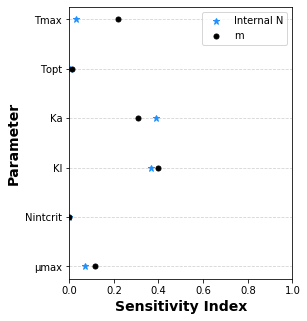

In [21]:
fig,ST2 = plt.subplots(1,1,sharex=True,figsize=(4,5))
#ST2.plot(Si3['ST'],problem['names'],'s',markersize=5,color='dimgray')
ST2.plot(Si2['ST'],problem['names'],'*',markersize=7,color='dodgerblue')
ST2.plot(Si1['ST'],problem['names'],'.',markersize=10,color='black')


ST2.set_xlabel('Sensitivity Index',fontsize=14, weight="bold")
ST2.set_ylabel('Parameter',fontsize=14, weight="bold")
ST2.set_xlim([0, 1])
ST2.set_axisbelow(True)
ST2.yaxis.grid(color='lightgray', linestyle='dashed')
ST2.legend(['Internal N','m'])


name = 'Outdoor Sensitivity.png' 
fig.savefig(fname=name, dpi=600)

In [22]:
a = param_values.T

a

array([[3.04931641e-02, 2.61474609e-02, 3.04931641e-02, ...,
        3.18237305e-02, 3.18237305e-02, 3.18237305e-02],
       [9.41699219e-01, 9.41699219e-01, 2.94853516e+00, ...,
        1.30913086e+00, 1.30913086e+00, 1.30913086e+00],
       [8.50048828e+01, 8.50048828e+01, 8.50048828e+01, ...,
        1.13283691e+02, 1.13283691e+02, 1.13283691e+02],
       [1.38583984e-01, 1.38583984e-01, 1.38583984e-01, ...,
        7.22509766e-02, 7.22509766e-02, 7.22509766e-02],
       [1.78027344e+01, 1.78027344e+01, 1.78027344e+01, ...,
        2.33837891e+01, 2.47802734e+01, 2.47802734e+01],
       [3.64433594e+01, 3.64433594e+01, 3.64433594e+01, ...,
        3.14658203e+01, 3.66279297e+01, 3.14658203e+01]])

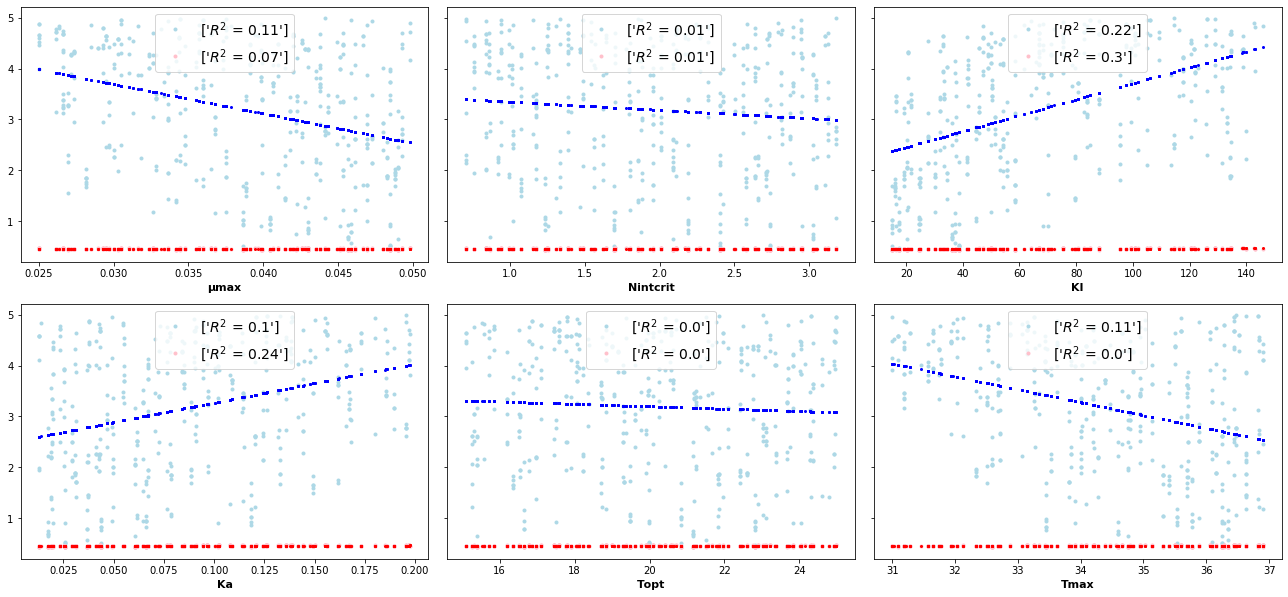

In [23]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 5) & (Y2[i] < 5):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(2,3,figsize=(18,8.4),sharey=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Error plots Outdoor.png' 
    
fig.savefig(fname=name, dpi=600)

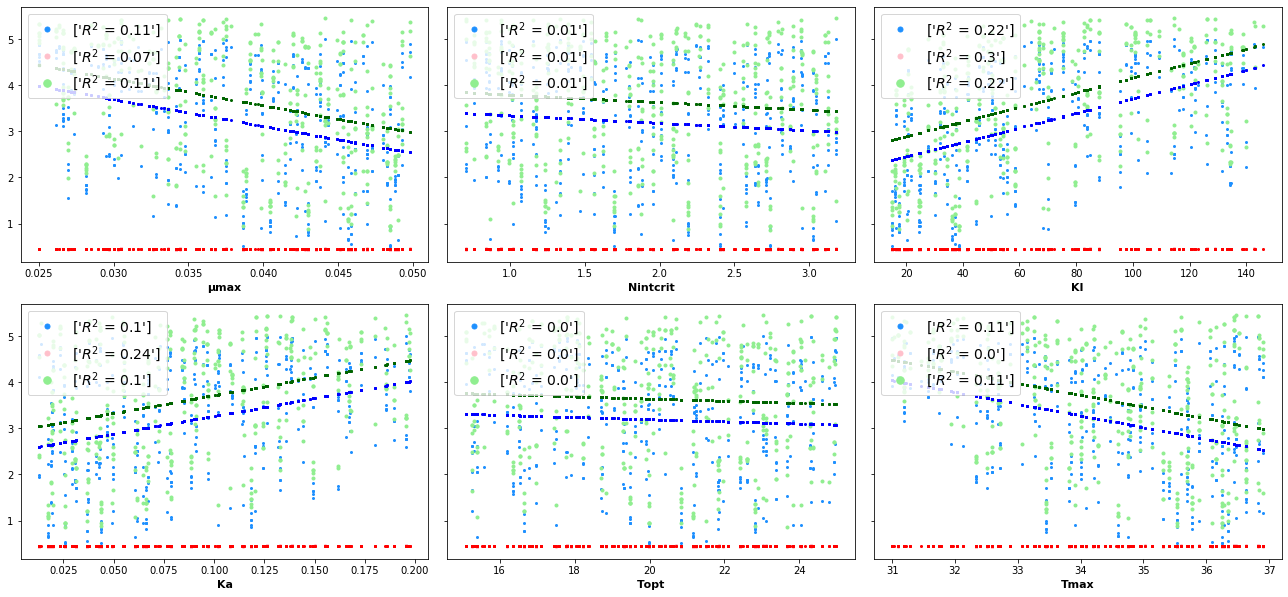

In [24]:
Y3 = Y1 + Y2
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 5) & (Y2[i] < 5):
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(2,3,figsize=(18,8.4),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'dodgerblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    
    # Combined (Y3)
    
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    #ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sqC = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')
    
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))],['$R^{2}$ = ' + str(round(r_sqC,2))]],fontsize = 14,loc = 'upper left',markerscale = 2.5)

    
plt.tight_layout()
plt.show()

name = 'Outdoor Full Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

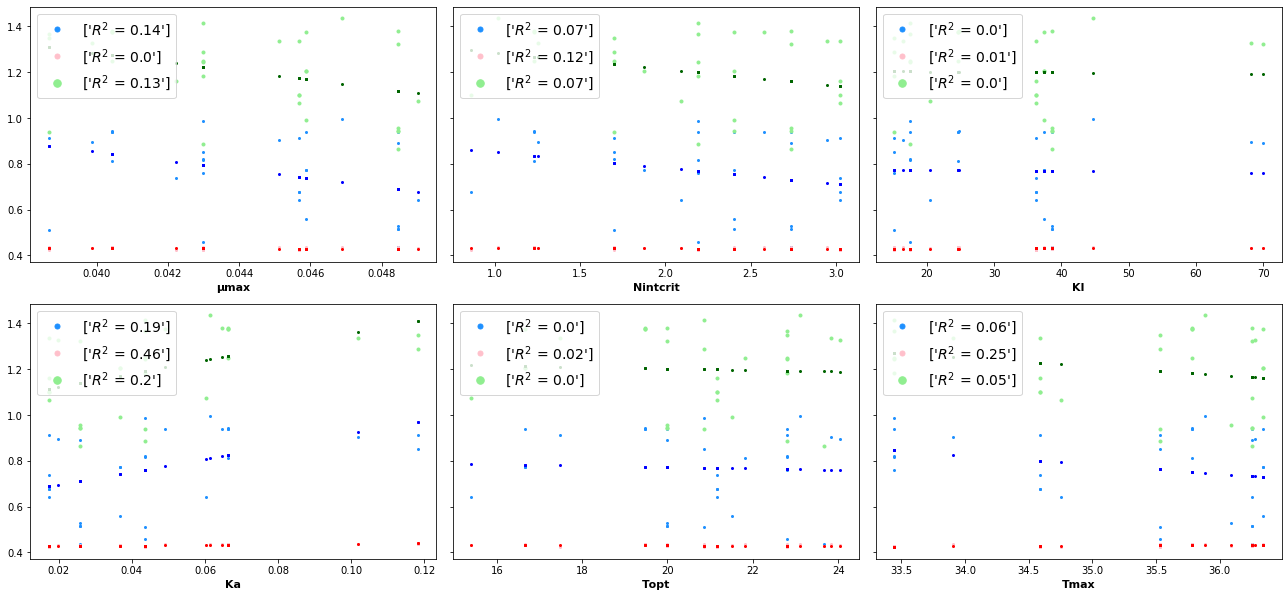

In [25]:
Y3 = Y1 + Y2
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 1) & (Y2[i] < 1):
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(2,3,figsize=(18,8.4),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'dodgerblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    
    # Combined (Y3)
    
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    #ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sqC = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')
    
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))],['$R^{2}$ = ' + str(round(r_sqC,2))]],fontsize = 14,loc = 'upper left',markerscale = 2.5)

    
plt.tight_layout()
plt.show()

name = 'Outdoor Error plots reduced.png' 
    
fig.savefig(fname=name, dpi=600)

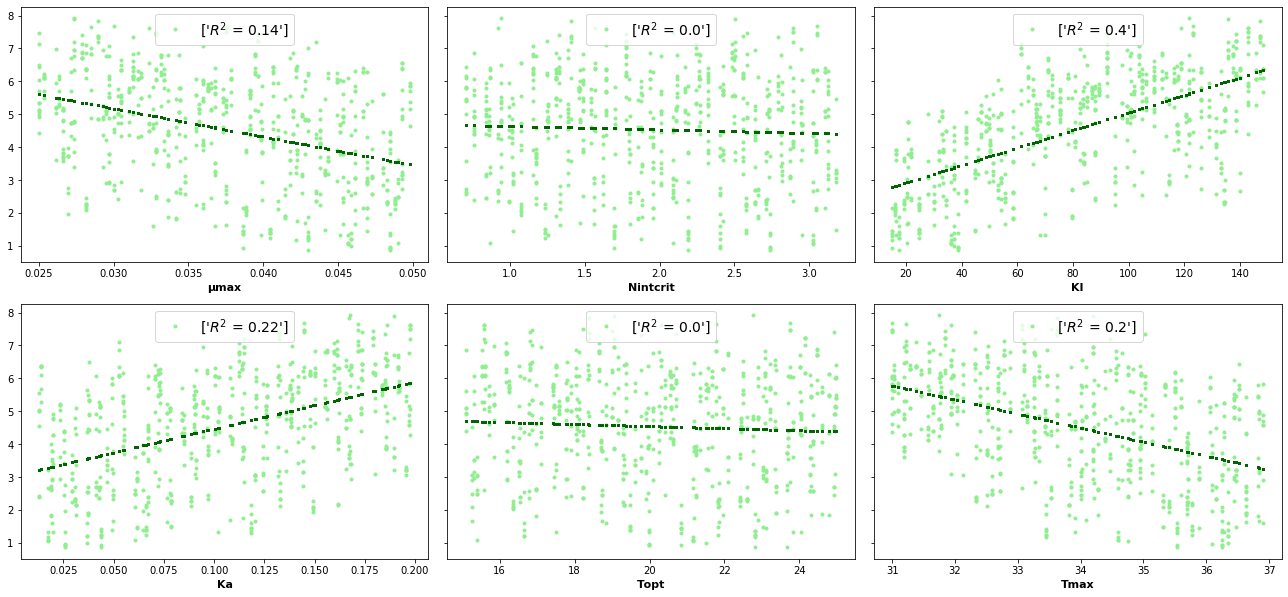

In [26]:
Y3 = Y1+Y2
Best_index = []
for i in range(len(Y3)):
    Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(2,3,figsize=(18,8.4),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sq = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Outdoor Combined Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

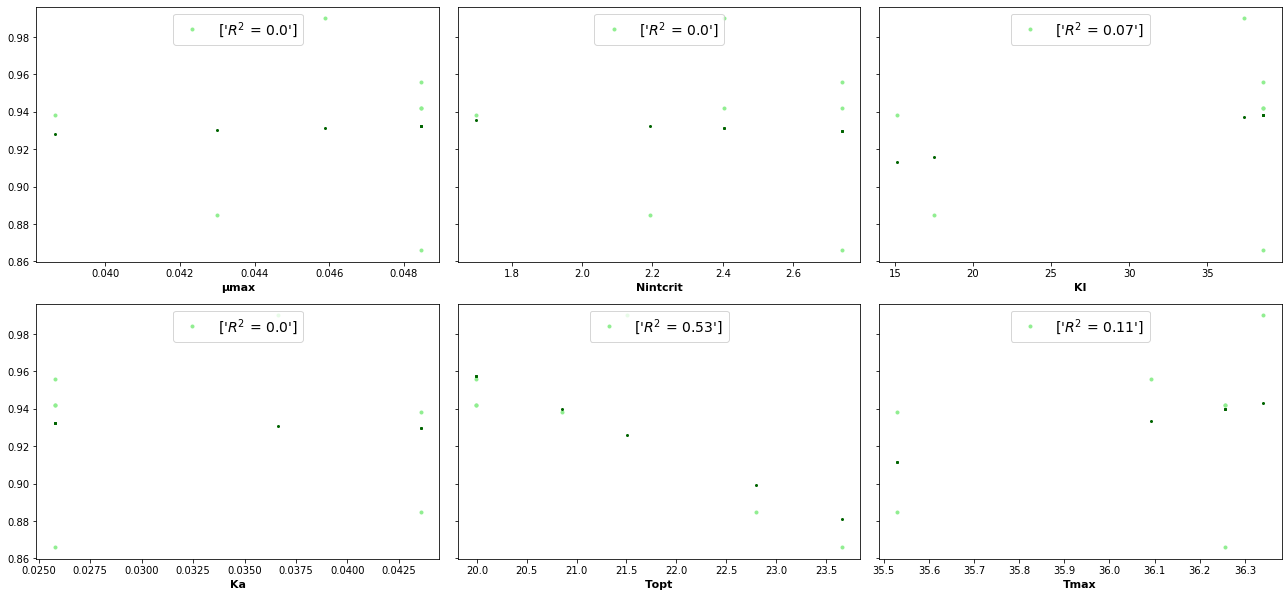

In [27]:
Y3 = Y1+Y2
Best_index = []
for i in range(len(Y3)):
    if Y3[i] < 1:
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(2,3,figsize=(18,8.4),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sq = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Outdoor Combined Reduced Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

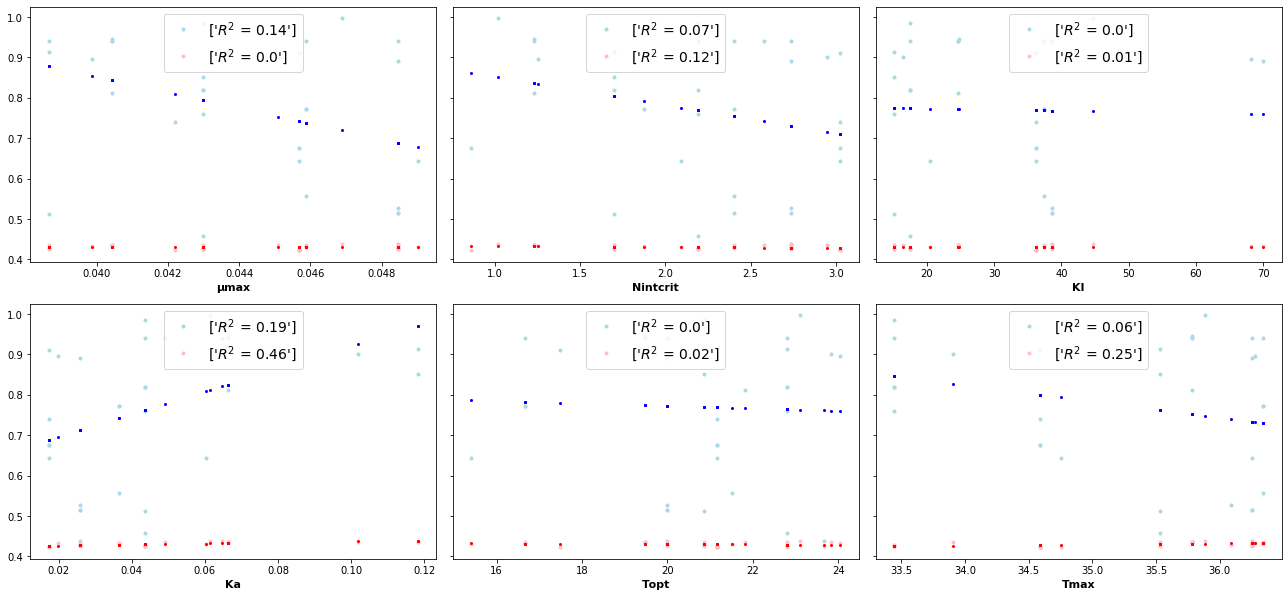

In [28]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 1) & (Y2[i] < 0.6):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(2,3,figsize=(18,8.4),sharey=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

In [29]:
Y1.tolist().index(min(Y1)),Y2.tolist().index(min(Y2)) 

(187, 203)

In [30]:
param_values[Y1.tolist().index(min(Y1))],param_values[Y2.tolist().index(min(Y2)) ]

(array([4.84619141e-02, 2.73857422e+00, 3.85986328e+01, 2.57714844e-02,
        2.36621094e+01, 3.62558594e+01]),
 array([4.22119141e-02, 3.02666016e+00, 3.62255859e+01, 1.72363281e-02,
        2.11621094e+01, 3.45917969e+01]))

In [31]:
problem

{'num_vars': 6,
 'names': ['µmax', 'Nintcrit', 'KI', 'Ka', 'Topt', 'Tmax'],
 'bounds': [[0.025, 0.05],
  [0.7, 3.2],
  [15, 150],
  [0.01, 0.2],
  [15, 25],
  [31, 37]]}

In [32]:
Y3 = Y1+Y2
minerrorm = min(Y1)
minerrorN = min(Y2)
minsumerrors = min(Y3)

merror_best = Y1[Y3.tolist().index(min(Y3))]
Nerror_best = Y2[Y3.tolist().index(min(Y3))]

indminerrorm = Y1.tolist().index(min(Y1))
indminerrorN = Y2.tolist().index(min(Y2))
BestParam_m = param_values[Y1.tolist().index(min(Y1))]
BestParam_N = param_values[Y2.tolist().index(min(Y2))]
BestParam = param_values[Y3.tolist().index(min(Y3))]

print('Minimum error for m: ' + str(minerrorm))
print('Minimum error for Nint: ' + str(minerrorN) + '\n')
print('Minimum sum of errors: ' + str(minsumerrors) + '\n')
print('Best error for m: ' + str(merror_best))
print('Best error for N: ' + str(Nerror_best))

for i in range(len(problem['names'])):
    print('Parameter: ' + str(problem['names'][i]) + ' Best values: ' + str(round(BestParam_m[i],3)) + ' , ' +str(round(BestParam_N[i],3)) + ' and: ' +str(round(BestParam[i],3))+'\n')

Minimum error for m: 0.439
Minimum error for Nint: 0.423

Minimum sum of errors: 0.866

Best error for m: 0.439
Best error for N: 0.427
Parameter: µmax Best values: 0.048 , 0.042 and: 0.048

Parameter: Nintcrit Best values: 2.739 , 3.027 and: 2.739

Parameter: KI Best values: 38.599 , 36.226 and: 38.599

Parameter: Ka Best values: 0.026 , 0.017 and: 0.026

Parameter: Topt Best values: 23.662 , 21.162 and: 23.662

Parameter: Tmax Best values: 36.256 , 34.592 and: 36.256

